In [1]:
%load_ext autoreload
%autoreload 2
import boto3
import os

from tools.document_summarizer import document_summarizer, document_summarizer_toolspec
from tools.image_summarizer import image_summarizer, image_summarizer_toolspec
from tools.country_canvas import country_canvas, country_canvas_toolspec
bedrock_runtime_client = boto3.client("bedrock-runtime", region_name='us-east-1')

Matplotlib is building the font cache; this may take a moment.


In [2]:
model_id_micro = "amazon.nova-micro-v1:0"

In [3]:
SYSTEM_PROMPT = """
You are an helpful AI assistant that provides for user-specified query using only
the Document_Summarzier_Tool or Architecture_Summazier_Tool or ,ImageGenerator_Tool which expects a query from the user. 
To use the tool, you strictly apply the provided tool specification.

- Explain your step-by-step process, and give brief updates before each step.
- Use the Document_Summazier_Tool for any summarization queries, Image_Summazier_Tool for Architecture image related queries,Canvas_Tool for given country..
- If only country name is mentioned, use ImageGenerator_Tool for image generation.
- If .png present in the query use Image_Summazier_Tool for architecture description.
- If .pdf present in the query use Document_Summazier_Tool for summary generation
- Repeat the tool use for subsequent requests if necessary.
- If the tool errors, apologize, explain information is unavailable, and suggest other options.
- Only respond to generic queries. Remind off-topic users of your purpose. 
- Complete the entire process until you have all required data before sending the complete response.
"""

In [8]:
#
# Step 4: Define the initial message and conversation
#
conversation = []
initial_message = {
    "role": "user",
    "content": [
        { "text": "Generate summary for document at location /home/ec2-user/SageMaker/aws-genai/AmazonNova/data/Intro_DVC_Tool.pdf" } #path from local
    ],
}
conversation.append(initial_message)

In [18]:
conversation = []
initial_message = {
    "role": "user",
    "content": [
        { "text": "/home/ec2-user/SageMaker/aws-genai/AmazonNova/data/Complex-AWS-Architecture.png" } #path from local
    ],
}
conversation.append(initial_message)

In [22]:
conversation = []
initial_message = {
    "role": "user",
    "content": [
        { "text": "Generate image for country india" }
    ],
}
conversation.append(initial_message)

In [23]:
#
# Step 5: Send the message with the tool config and system prompt
#
SUMMARIZER_SPEC_TOOL = document_summarizer_toolspec()
IMAGE_SUMMARIZER_SPEC_TOOL = image_summarizer_toolspec()
COUNTRY_CANVAS_SPEC_TOOL = country_canvas_toolspec()
response = bedrock_runtime_client.converse(
    modelId=model_id_micro,
    messages=conversation,
    inferenceConfig={
        "maxTokens": 2000,
        "temperature": 0
    },
    toolConfig={
            "tools": [SUMMARIZER_SPEC_TOOL, IMAGE_SUMMARIZER_SPEC_TOOL, COUNTRY_CANVAS_SPEC_TOOL]
    },
    system=[{"text": SYSTEM_PROMPT}]
)

In [24]:
response

{'ResponseMetadata': {'RequestId': 'c21454fd-03b1-4092-9839-344bdcf2151e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 18 Feb 2025 08:26:47 GMT',
   'content-type': 'application/json',
   'content-length': '534',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c21454fd-03b1-4092-9839-344bdcf2151e'},
  'RetryAttempts': 0},
 'output': {'message': {'role': 'assistant',
   'content': [{'text': '<thinking> The user has requested an image for the country India. Based on the provided tools, the appropriate tool for generating an image of a country is the Country_Canvas_Tool. I will use this tool to generate the image.</thinking>\n'},
    {'toolUse': {'toolUseId': 'tooluse_-7HzBoikT-6DKDs1o_cRHg',
      'name': 'Country_Canvas_Tool',
      'input': {'query': 'India'}}}]}},
 'stopReason': 'tool_use',
 'usage': {'inputTokens': 761, 'outputTokens': 98, 'totalTokens': 859},
 'metrics': {'latencyMs': 542}}

<thinking> The user has requested an image for the country India. Based on the provided tools, the appropriate tool for generating an image of a country is the Country_Canvas_Tool. I will use this tool to generate the image.</thinking>



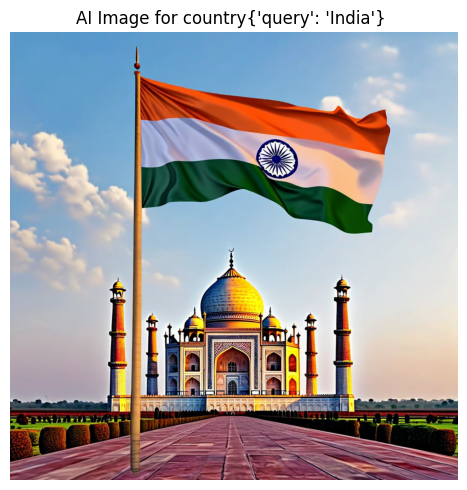

In [27]:
response_message = response['output']['message']
conversation.append(response_message)
response_content_blocks = response_message['content']

follow_up_content_blocks = []

for content_block in response_content_blocks:
    if 'text' in content_block:
      print(content_block['text'])
    elif 'toolUse' in content_block:
      tool_use_block = content_block['toolUse']
      tool_use_name = tool_use_block['name']

      if tool_use_name == 'Document_Summazier_Tool':
        print(tool_use_block['input']['query'])
        tool_result_value = document_summarizer(tool_use_block['input']['query'])
        ## for follow up queries
        follow_up_content_blocks.append({
            "toolResult": {
                "toolUseId": tool_use_block['toolUseId'],
                "content": [
                    {
                        "json": {
                            "result": tool_result_value
                        }
                    }
                ]
            }
        })
      elif tool_use_name == 'Image_Summazier_Tool':
        image_summarizer(tool_use_block['input']['query'])
        
        ## for follow up queries
        follow_up_content_blocks.append({
            "toolResult": {
                "toolUseId": tool_use_block['toolUseId'],
                "content": [
                    {
                        "json": {
                            "result": tool_result_value
                        }
                    }
                ]
            }
        })
        
      elif tool_use_name == 'Country_Canvas_Tool':
        country_canvas(tool_use_block['input'])
        
        ## for follow up queries
        follow_up_content_blocks.append({
            "toolResult": {
                "toolUseId": tool_use_block['toolUseId'],
                "content": [
                    {
                        "json": {
                            "result": tool_result_value
                        }
                    }
                ]
            }
        })
     
      # Handle unknown tools
      else:
        follow_up_content_blocks.append({
          "toolResult": {
            "toolUseId": tool_use_block['toolUseId'],
            "content": [
                {
                    "text": "unknown tool" + tool_use_name
              
                }
            ],
            "status": "error"
          }
        })